In [ ]:
#This script uses the function in the modules "block_structure_charge_drift" (general FVM functions), 
#block_structure_drift_strip" (drift-only motion), "block_structure_drift_diffusion_strip" (drift-diffusion motion)
#and the solvers in "Solvers_residual" to calculate the time-evolution of the charge distribution liberated by an
#ionizing particle in the silicon detector

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from block_structure_drift_strip import *
from Solvers_residual import *
from block_structure_charge_drift import *
import multiprocessing as mp
from block_structure_drift_diffusion_strip import *

In [2]:
#define the dimensions of the solution domain
pitch = 100
height = 300
mesh_size = 0.1
N_x = int(pitch/mesh_size)
N_y = int(height/mesh_size)
active_cells = int(N_x*N_y)

#define the mobilities of electrons and holes
mobility_e = 1350*10**(-4) #m^2 s^-1 V^-1
mobility_h = 450*10**(-4) #m^2 s^-1 V^-1

#time steps for electrons and holes
time_step_e = 0.002*10**(-9) #s
time_step_e_ns = 0.002
time_step_h= 0.006*10**(-9) #s
time_step_h_ns = 0.006

In [5]:
#load the potential distribution inside the silicon detector

potential_distr = pd.read_csv("total_potential_30V_R=1.csv", header = None)
potential_distr = np.array(potential_distr)

np.shape(potential_distr) #check that it matches the dimensions of the solution domain

(3000, 1000)

In [6]:
#flatten the potential distribution to a 1D vector
potential = []

for i in range(N_y):
    for j in range(N_x):
        potential.append(potential_distr[i, j])

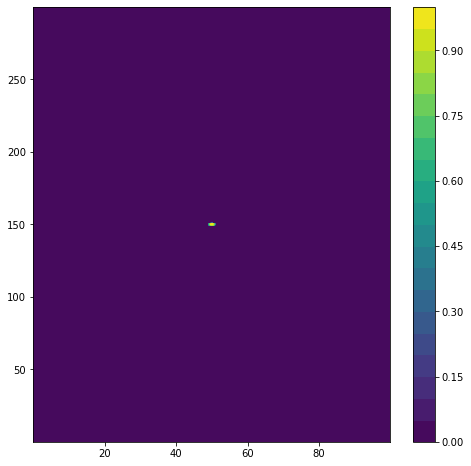

In [7]:
#Define the initial concentration

#centre and radius of the initial sherical distribution
x_0 = 50
y_0 = 150
r_0 = 1

#number of cells in the globule of charge, used in drift-only case to correct for the over-shoots
cells_in_globule = (np.pi*r_0**2)/(mesh_size**2)

#surface density distribution as a result of the projection of the globule of charge to 2D
def conc_0(radius_squared):
    rho = 1*np.sqrt((r_0)**2 - radius_squared) #divide everything by the actual rho_0
    return rho

#define the concentration in 2D
x = np.arange(0 + mesh_size/2, pitch, mesh_size)
y = np.arange(0 + mesh_size/2, height, mesh_size)

X, Y = np.meshgrid(x, y)

concentration_plane_0 = np.zeros((N_y, N_x))

for i in range(N_y):
    for j in range(N_x):
        
        loc_x = X[i, j]
        loc_y = Y[i, j]
        
        radius_squared = ((loc_x - x_0)**2 + (loc_y - y_0)**2)
        
        if  radius_squared < r_0**2:
            concentration_plane_0[i, j] = conc_0(radius_squared)
        else:
            continue
            
#eliminate concentration from critical locations (inactive cells, cells with no electric field)
for i in range(N_y-3, N_y):
    for j in range(N_x):
        concentration_plane_0[i, j] = 0
        
for i in range(N_y):
    for j in range(4):
        concentration_plane_0[i, j] = 0

#flatten the concentration to a 1D vector
concentration_0 = []

for i in range(N_y):
    for j in range(N_x):
        
        concentration_0.append(concentration_plane_0[i, j])
        
#same distribution for both holes and e since they are produced in pairs

#plot initial concentration
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
cax = ax.contourf(X, Y, concentration_plane_0, 20)
fig.colorbar(cax)

In [8]:
#QUICK CRANK-NICOLSON

#electrons

#define the matrix of coefficiernts and the matrix of positions
#full coefficients matrix and positions matrix
coeff_e, position_e = drift_block_strip_diff(height, pitch, potential, mobility_e, -1, time_step_e, "c")

#calculate the UD part of the matrix and the 2nd order part, needed for deferred correction solution method
coeff_e_UD = drift_block_strip_diff_UD_part(height, pitch, position_e, potential, mobility_e, -1, time_step_e, "c")
coeff_e_correction = drift_block_strip_correction_part(height, pitch, position_e, potential, mobility_e, -1, time_step_e, "c")

In [9]:
#QUICK CRANK-NICOLSON

#holes

#define the matrix of coefficiernts and the matrix of positions
#full coefficients matrix and positions matrix
coeff_h, position_h = drift_block_strip_diff(height, pitch, potential, mobility_h, 1, time_step_h, "c")

#calculate the UD part of the matrix and the 2nd order part, needed for deferred correction solution method
coeff_h_UD = drift_block_strip_diff_UD_part(height, pitch, position_h, potential, mobility_h, 1, time_step_h, "c")
coeff_h_correction = drift_block_strip_correction_part(height, pitch, position_h, potential, mobility_h, 1, time_step_h, "c")

In [10]:
#check that dimensions match
print(np.shape(coeff_e), np.shape(position_e))
print(np.shape(coeff_e_UD))
print(np.shape(coeff_e_correction))

(3000000, 7) (3000000, 7)
(3000000, 7)
(3000000, 7)


In [11]:
#check that dimensions match
print(np.shape(coeff_e), np.shape(position_e))
print(np.shape(coeff_h), np.shape(position_h))
print(np.shape(coeff_e_UD), np.shape(coeff_h_UD))
print(np.shape(coeff_e_correction), np.shape(coeff_h_correction))

(3000000, 7) (3000000, 7)
(3000000, 7) (3000000, 7)
(3000000, 7) (3000000, 7)
(3000000, 7) (3000000, 7)


In [12]:
#initial condition for both electrons and holes

#total concentration
initial_total_concentration = np.sum(concentration_0)
print("initial concentration:")
print(initial_total_concentration)

total_concentration_e = initial_total_concentration
total_concentration_h = initial_total_concentration

#creating the initial concentratuon vectors
concentration_e = np.copy(concentration_0)
concentration_h = np.copy(concentration_0)

#time step tracking
time_e = 0
time_h = 0

#minimum concentration for the definition of the active domain
minimum_conc = 10**(-5)
start_end_guess = (0, active_cells)
start_end = find_start_end(concentration_0, start_end_guess, active_cells, minimum_conc) #find the initial and final cells
                                                                                         #of the active domain

#define start and end cells of active domain for both electrons and holes
start_end_e = start_end
start_end_h = start_end

print(start_end_e)
print(start_end_h)

initial concentration:
209.91179472231562
(1440247, 1559252)
(1440247, 1559252)


In [13]:
#create the sources assuming that the right and left boundaries conduct no flux

#source of electrons

source_e = QUICK_drift_source_CN(height, pitch, coeff_e, position_e, concentration_e, mobility_e, time_step_e)

#source of holes

source_h = QUICK_drift_source_CN(height, pitch, coeff_h, position_h, concentration_h, mobility_h, time_step_h)

In [14]:
#correction function - for diffusive motion, only removes negative values (might occur due to numerical errors)
#the numerical scheme is stable thanks to the stabilising effect of diffusion

def correction_conc_diff(concentration, tolerance): #concentration: concentration vector
                                                    #tolerance: minimum concentration that triggers setting to 0
                                                    #useful in numerical errors removal
    #manual correction to remove negative values
    for n in range(active_cells):
        if concentration[n] < tolerance:
            concentration[n] = 0
        
    return concentration

#correction function - for drift-only motion
#1) removes negative values
#2) removes positive over-shoots

#additional variables
#initial_total_concentration: total concentration at t = 0
#cells_in_globule: total number of cells making up the initial concentration assuming a perfect circle

def correction_conc_drift(concentration, tolerance, initial_total_concentration, cells_in_globule):
    
    #manual correction to remove negative values
    for n in range(active_cells):
        if concentration[n] < tolerance:
            concentration[n] = 0

    total_concentration = np.sum(concentration)
    print(total_concentration) #after removal of negative values

    #CORRECTION PART OF THE FUNCTION
    ###########################################################################################################################
    #manual correction to remove part of the up-shoots
    difference_concentration = total_concentration - initial_total_concentration
    #difference total concentration without negative values and initial concentration
    correction_concentration = difference_concentration/cells_in_globule
    #extra concentration per cell in the spherical distribution (assuming minimal spreading in drift-only scenario)
    max_concentration = np.amax(concentration)
    #maximum concnetration

    #apply the correction as long as there are (overall) upshoots and the globule hasn't reached the opposite electrode (concentration will suddenly drop)
    if correction_concentration > 0:
        for n in range(active_cells):
            if concentration[n] > 0.1*max_concentration:
                concentration[n] = concentration[n] - correction_concentration #subtract the correction

    new_total_concentration = np.sum(concentration)
    print(new_total_concentration)
    #check the value of the new total concentration of the distribution
        
    return concentration, new_total_concentration #return concentration vector and total concentration

#this function creates the vectors to be saved as csv files
#only save concentration in active domain (saving memory)
#append the start and end cells in order to be able to reconstrct the concentration

def file_creator(concentration, start_end): #concentration: concentration vector
                                            #start_end: start and end cells of active domain
    save_file = []
    
    start, end = start_end
    
    for n in range(start, end):
        save_file.append(concentration[n])
        
    save_file.append(start)
    save_file.append(end)
    
    return save_file

In [ ]:
#use multiprocessing to calculate the electron and hole time evolution in parallel

while total_concentration_e > 10**(-1) and total_concentration_h > 10**(-1): #define charge collection tolerance
    
    #define active domains for electrons and holes
    start_end_e = find_start_end(concentration_e, start_end_e, active_cells, 10**(-5))
    start_end_h = find_start_end(concentration_h, start_end_h, active_cells, 10**(-5))
    
    #open pool of workers
    pool = mp.Pool(2)
    
    #update the source vector using values from previous iteration
    out_source_e = pool.apply_async(QUICK_drift_source_CN_optimised, args = (height, pitch, coeff_e, position_e, start_end_e, concentration_e, mobility_e, time_step_e)) 
    out_source_h = pool.apply_async(QUICK_drift_source_CN_optimised, args = (height, pitch, coeff_h, position_h, start_end_h, concentration_h, mobility_h, time_step_h))
    source_e = out_source_e.get()
    source_h = out_source_h.get()
    
    print(np.sum(source_e))
    print(np.sum(source_h))
    
    #start time-advancement
    R_e = 1
    R_h = 1
    iteration = 0
    while R_e > 10**(-5) or R_h > 10**(-6):
        
        #apply one iteration of SOR method
        out_conc_e = pool.apply_async(SOR_solver_7diagonals_one_iter_2, args = (coeff_e, coeff_e_UD, coeff_e_correction, position_e, source_e, concentration_e, concentration_e, 1, start_end_e, active_cells))
        out_conc_h = pool.apply_async(SOR_solver_7diagonals_one_iter_2, args = (coeff_h, coeff_h_UD, coeff_h_correction, position_h, source_h, concentration_h, concentration_h, 1, start_end_h, active_cells))
        concentration_e, R_e = out_conc_e.get()
        concentration_h, R_h = out_conc_h.get()
        
        print(iteration, R_e, R_h)
        iteration = iteration + 1

    pool.close()
    #close pool of workers
    
    start_e, end_e = start_end_e
    start_h, end_h = start_end_h
    
    #correct the concentrations
    concentration_e = correction_conc_diff(concentration_e, 0)
    concentration_h = correction_conc_diff(concentration_h, 0)
    
    #check total concentration and active domain
    total_concentration_e = np.sum(concentration_e)
    total_concentration_h = np.sum(concentration_h)
    
    print("Total e =" + str(total_concentration_e))
    print("Total h =" + str(total_concentration_h))
    print(start_end_e)
    print(start_end_h)
    
    #create vectors for csv files
    save_file_e = file_creator(concentration_e, start_end_e)
    save_file_h = file_creator(concentration_h, start_end_h)
    N_e = len(save_file_e)
    N_h = len(save_file_h)
    print(np.sum(save_file_e[0:N_e-2]))
    print(np.sum(save_file_h[0:N_h-2]))
    
    #save the files
    if total_concentration_e > 0:
        time_e = time_e + time_step_e_ns
        str_time_e = str("%.3f" % time_e)
        print("time_e = " + str_time_e + "ns")

        string_e = "concentration_e_" + str_time_e + "ns.csv"
        np.savetxt(string_e, save_file_e, delimiter = ",")

    if total_concentration_h > 0:
        time_h = time_h + time_step_h_ns
        str_time_h = str("%.3f" % time_h)
        print("time_h = " + str_time_h + "ns")

        string_h = "concentration_h_" + str_time_h + "ns.csv"
        np.savetxt(string_h, save_file_h, delimiter = ",")

#simce one charge species will be collected before the other, when the above loop breaks, one of the two
#loops below will complete the time evolution of the charge species that hasn't been yet collected
        
while total_concentration_h > 10**(-1):
    
    source_h = QUICK_drift_source_CN_optimised(height, pitch, coeff_h, position_h, start_end_h, concentration_h, mobility_h, time_step_h)
    
    concentration_h, start_end_h = SOR_solver_7diagonals_2(coeff_h, coeff_h_UD, coeff_h_correction, position_h, source_h, concentration_h, 1, 10**(-6), 10**(-5), start_end_h, active_cells)
    
    start, end = start_end_e
    
    if end > (active_cells - 100):
        concentration_h = correction_conc(concentration_h, 0)
    
    total_concentration_h = np.sum(concentration_h)
    
    print("Total h =" + str(total_concentration_h))
    print(start_end_h)
    
    save_file_h = file_creator(concentration_h, start_end_h)
    
    if total_concentration_h > 0:
        time_h = time_h + time_step_h_ns
        str_time_h = str("%.3f" % time_h)
        print("time_h = " + str_time_h + "ns")

        string_h = "concentration_h_" + str_time_h + "ns.csv"
        np.savetxt(string_h, save_file_h, delimiter = ",")
        
while total_concentration_e > 10**(-1):
    
    source_e = QUICK_drift_source_CN_optimised(height, pitch, coeff_e, position_e, start_end_e, concentration_e, mobility_e, time_step_e)
    
    concentration_e, start_end_e = SOR_solver_7diagonals_2(coeff_e, coeff_e_UD, coeff_e_correction, position_e, source_e, concentration_e, 1, 10**(-6), 10**(-5), start_end_e, active_cells)
    
    start, end = start_end_e
    
    if start < 100:
        concentration_e = correction_conc(concentration_e, 0)
    
    total_concentration_e = np.sum(concentration_e)
    
    print("Total e =" + str(total_concentration_e))
    print(start_end_e)
    
    save_file_e = file_creator(concentration_e, start_end_e)
    
    if total_concentration_e > 0:
        time_e = time_e + time_step_e_ns
        str_time_e = str("%.3f" % time_e)
        print("time_e = " + str_time_e + "ns")

        string_e = "concentration_e_" + str_time_e + "ns.csv"
        np.savetxt(string_e, save_file_e, delimiter = ",")